StudentID: 202314466

In [1]:
# import all the libraries that we need
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score
from numpy import argmax
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

We start by exploring the dataset ('dataset1.xlsx') by reading the excel file.

In [2]:
dataset_pd = pd.read_excel('dataset1.xlsx')
dataset_pd

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35
...,...,...,...,...,...,...,...,...
920,0,422.34,547.259,Belarus,NaN,350.45,yes,2019-01-22 12:58:14
921,1,342.62,473.919,Japan,NaN,200.85,no,2019-02-01 14:37:34
922,1,265.10,538.170,Saint Martin,NaN,208.35,yes,2019-06-13 18:50:00
923,0,397.12,622.386,Chad,NaN,433.45,yes,2019-05-27 06:19:27


After successful reading 'dataset1.xlsx', we check the dataset for missing values, the summary statistics of the dataset and the dataset frame data types.Knowing the data types of the various columns will help in knowing how to work on the missing values.

In [3]:
dataset_pd.isna().sum() # checking for missing values per column

target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64

In [4]:
dataset_pd.dtypes # data types of the various columns

target      int64
var1      float64
var2      float64
var3       object
var4      float64
var5      float64
var6       object
var7       object
dtype: object

In [5]:
dataset_pd.describe() #  display the summary statistics of the dataset 

,target,var1,var2,var4,var5
count,925.000000,925.000000,925.000000,325.000000,925.000000
mean,0.496216,360.116562,548.390134,108.452308,325.393946
std,0.500256,87.866662,135.221460,26.325744,78.862779
min,0.000000,209.560000,139.965000,57.000000,163.000000
25%,0.000000,278.640000,467.373000,87.000000,257.900000
50%,0.000000,367.640000,569.841000,105.000000,342.350000
75%,1.000000,437.600000,652.278000,126.000000,393.000000
max,1.000000,539.920000,794.848000,180.000000,457.150000


From the dataset, we can see we have missing values only in var4. The total sum of missing values in var4 is 600. This is quite huge for a dataset with 925 records. So, we can't drop them. Therefore, we shall try predict the missing values based on the data that we have. We shall start by analyzing the columns one by one as we prepare the data to predict the missing values.

In [6]:
dataset_pd.head() # lets us display a sample of 5 records in the dataset for analysis

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


From the dataset we can see, 'var3' and 'var6' are categorical features. Let us use the One-Hot encoder for 'var6' first to convert 'yes' values to 1 and 'no' values to 0

In [7]:
# define one hot encoding
encoder = OneHotEncoder(sparse_output=False, dtype=int)

# transform categorical data into numerical using one-hot encoding
onehot = encoder.fit_transform(dataset_pd[['var6']])

# assign the encoded values back to 'var6' column
dataset_pd['var6'] = onehot.take(1, axis=1)

# show the dataframe
dataset_pd.head()

,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,0,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,1,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,0,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,1,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,0,2019-03-18 13:22:35


'var3' column contains country names, so we can neither use OneHotEncoder as we need multiple values nor OrdinalEncoder as countries are not ordered naturally.

We can try use TargetEncoder for encoding as it is best suited for high cardinality categories such as location based zip code or region (https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features)

Since TargetEncoder appears in scikit-learn starting from version 1.3, we will use the implementation from here: https://contrib.scikit-learn.org/category_encoders/targetencoder.html

Let us observe what target values correspond to some values of the 'var3' column

In [8]:
dataset_pd[dataset_pd['var3']=='Japan']

,target,var1,var2,var3,var4,var5,var6,var7
343,0,457.62,472.586,Japan,NaN,381.00,0,2019-03-02 06:35:08
460,1,338.80,310.724,Japan,NaN,356.65,1,2019-03-15 06:54:21
714,0,332.62,721.889,Japan,NaN,357.00,1,2019-05-24 17:07:08
921,1,342.62,473.919,Japan,NaN,200.85,0,2019-02-01 14:37:34


In [9]:
chad = dataset_pd[dataset_pd['var3']=='Chad']
chad

,target,var1,var2,var3,var4,var5,var6,var7
9,1,283.04,467.801,Chad,69.0,272.35,1,2019-03-26 19:37:46
60,1,398.50,567.351,Chad,150.0,186.60,0,2019-03-30 23:40:52
76,0,496.38,562.166,Chad,117.0,405.55,0,2019-07-13 11:41:29
923,0,397.12,622.386,Chad,NaN,433.45,1,2019-05-27 06:19:27


In [10]:
sm = dataset_pd[dataset_pd['var3']=='Saint Martin']
sm

,target,var1,var2,var3,var4,var5,var6,var7
485,0,425.76,674.325,Saint Martin,NaN,409.90,1,2019-06-04 09:25:27
768,1,256.74,624.637,Saint Martin,NaN,244.30,0,2019-01-04 00:44:57
783,0,444.70,651.866,Saint Martin,NaN,406.25,0,2019-04-16 14:15:55
922,1,265.10,538.170,Saint Martin,NaN,208.35,1,2019-06-13 18:50:00


In our case target values that correspond to 'Japan', 'Chad, 'Saint Martin' are the same. This means that TargetEncoder will produce the same values for these countries which is not good as we want a unique value for every country.

Let us use simple hashing for 'var3' column encoding. We will take last eight digits of the hashed values. This will be enough to provide uniqueness.

In [11]:
# calculate and store hashed values for each row in the 'var3' column
for rowNo in range(len(dataset_pd)):
  dataset_pd.loc[rowNo:rowNo, 'var3Hashed'] = abs(hash(dataset_pd.at[rowNo,'var3'])) % (10 ** 8)

# count the number of unique values in each column, including the 'var3Hashed' column
unique_counts = dataset_pd.nunique()

# display the number of unique values for each column
print(unique_counts)

target          2
var1          898
var2          925
var3          236
var4           41
var5          835
var6            2
var7          925
var3Hashed    236
dtype: int64


We can see that the number of unique hashed values ('var3Hashed' column) is equal to the number of unique original values ('var3' column). This means that there are no collisions in the hash calculation, and each unique value in 'var3' is mapped to a unique hashed value in 'var3Hashed'. So this means that the hashing function used ensures that each original value in 'var3' is uniquely represented in the 'var3Hashed' column.

In [12]:
dataset_pd.describe() #  display the summary statistics of the dataset 

,target,var1,var2,var4,var5,var6,var3Hashed
count,925.000000,925.000000,925.000000,325.000000,925.000000,925.000000,9.250000e+02
mean,0.496216,360.116562,548.390134,108.452308,325.393946,0.522162,5.399528e+07
std,0.500256,87.866662,135.221460,26.325744,78.862779,0.499779,3.011774e+07
min,0.000000,209.560000,139.965000,57.000000,163.000000,0.000000,1.795810e+05
25%,0.000000,278.640000,467.373000,87.000000,257.900000,0.000000,2.797250e+07
50%,0.000000,367.640000,569.841000,105.000000,342.350000,1.000000,5.423657e+07
75%,1.000000,437.600000,652.278000,126.000000,393.000000,1.000000,8.276466e+07
max,1.000000,539.920000,794.848000,180.000000,457.150000,1.000000,9.977171e+07


Now let us convert datetime values in 'var7' column to numbers.
First we will fix incorrect dates - 2019-02-29 is an error as 2019 was not a leap year. So we will change the date to 2019-02-28.

In [13]:
# fix incorrect date '2019-02-29' to '2019-02-28', 2019 was not a leap year
dataset_pd[dataset_pd['var7'].str[5:10] == '02-29'] 

,target,var1,var2,var3,var4,var5,var6,var7,var3Hashed
345,0,502.00,577.569,Angola,NaN,360.05,1,2019-02-29 12:31:57,16158341.0
526,1,343.80,525.632,Guadeloupe,NaN,271.95,0,2019-02-29 18:06:21,61996806.0
632,0,463.08,516.361,Ireland,NaN,407.30,1,2019-02-29 11:00:06,25096304.0
779,1,273.70,199.917,Madagascar,NaN,319.40,1,2019-02-29 23:56:06,76446434.0
813,0,357.02,750.444,Barbados,NaN,381.00,1,2019-02-29 19:26:35,78956434.0


In [14]:
# fix incorrect date '2019-02-29' to '2019-02-28', 2019 was not a leap year
dataset_pd.loc[dataset_pd.var7.str[5:10] == '02-29', 'var7'] = dataset_pd.var7.str.replace('02-29', '02-28')

# check if there are any rows with '02-29' in the 'var7' column
invalid_dates = dataset_pd[dataset_pd['var7'].str[5:10] == '02-29']
print(invalid_dates)

Empty DataFrame
Columns: [target, var1, var2, var3, var4, var5, var6, var7, var3Hashed]
Index: []


We shall now perform data normalization to rescale numerical features to a common range, typically between 0 and 1. This is particularly useful when the features have different scales, and we want to bring them to a standardized range for better model performance. In our case, we shall use the MinMaxScaler.

In [15]:
# convert each datetime value to a Unix timestamp, which is a numeric representation of time
dataset_pd['var7'] = pd.to_datetime(dataset_pd['var7'])
dataset_pd['var7'] = dataset_pd.var7.astype('int64')

# initialize Min-Max scaler
scaler = MinMaxScaler()

# select the columns to be normalized and apply Min-Max scaling to the selected columns
columns_to_normalize = ['var1', 'var2', 'var3Hashed', 'var4', 'var5', 'var7']
min_max_scaled_data = scaler.fit_transform(dataset_pd[columns_to_normalize])

# update the original DataFrame with normalized values and print the dataframe
dataset_pd[columns_to_normalize] = min_max_scaled_data
dataset_pd.head()

,target,var1,var2,var3,var4,var5,var6,var7,var3Hashed
0,0,0.906950,0.424070,Micronesia,0.658537,0.781914,0,0.983027,0.081415
1,0,0.715886,0.803528,Dominica,0.195122,0.642699,1,0.459632,0.108762
2,1,0.078520,0.394165,Isle of Man,0.268293,0.598334,0,0.298817,0.591861
3,0,0.291985,0.577505,Turkmenistan,0.365854,0.939147,1,0.378358,0.464784
4,0,0.737135,0.702707,Cameroon,0.390244,0.883733,0,0.374547,0.889349


In [16]:
dataset_pd.describe() # summary of statistics to check any loss of data

,target,var1,var2,var4,var5,var6,var7,var3Hashed
count,925.000000,925.000000,925.000000,325.000000,925.000000,925.000000,925.000000,925.000000
mean,0.496216,0.455735,0.623661,0.418311,0.552079,0.522162,0.492139,0.540361
std,0.500256,0.265972,0.206482,0.214030,0.268104,0.499779,0.287460,0.302411
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.209105,0.499949,0.243902,0.322625,0.000000,0.239056,0.279067
50%,0.000000,0.478508,0.656416,0.390244,0.609723,1.000000,0.483147,0.542784
75%,1.000000,0.690277,0.782297,0.560976,0.781914,1.000000,0.737341,0.829233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We shall now use ML to try predict our missing values. We will split 325 rows with complete data into train and test datasets. Then train and test an ML model on this data and predict empty 600 values for 'var4'

In [17]:
# separate complete data from data with missing values
var4_complete = dataset_pd[dataset_pd.var4.isna()==False]
var4_missing = dataset_pd[dataset_pd.var4.isna()]

print("Complete data: ",var4_complete.shape[0])
print("Missing data: ",var4_missing.shape[0])

Complete data:  325
Missing data:  600


In [18]:
# assign all columns apart from var4 from the DataFrame to variable X
X = var4_complete[['var1', 'var2','var3Hashed','var5','var6','var7']]

# target variable (y) is assigned to 'var4'
y = var4_complete['var4']

# splitting the dataset into train (80%) / test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('size of X_train dataset:',len(X_train))
print('size of Y_train dataset:',len(y_train))
print('size of X_test dataset:',len(X_test))
print('size of Y_test dataset:',len(y_test))

size of X_train dataset: 260
size of Y_train dataset: 260
size of X_test dataset: 65
size of Y_test dataset: 65


Let us see if we can observe some dependency between 'var4' and other features visually.

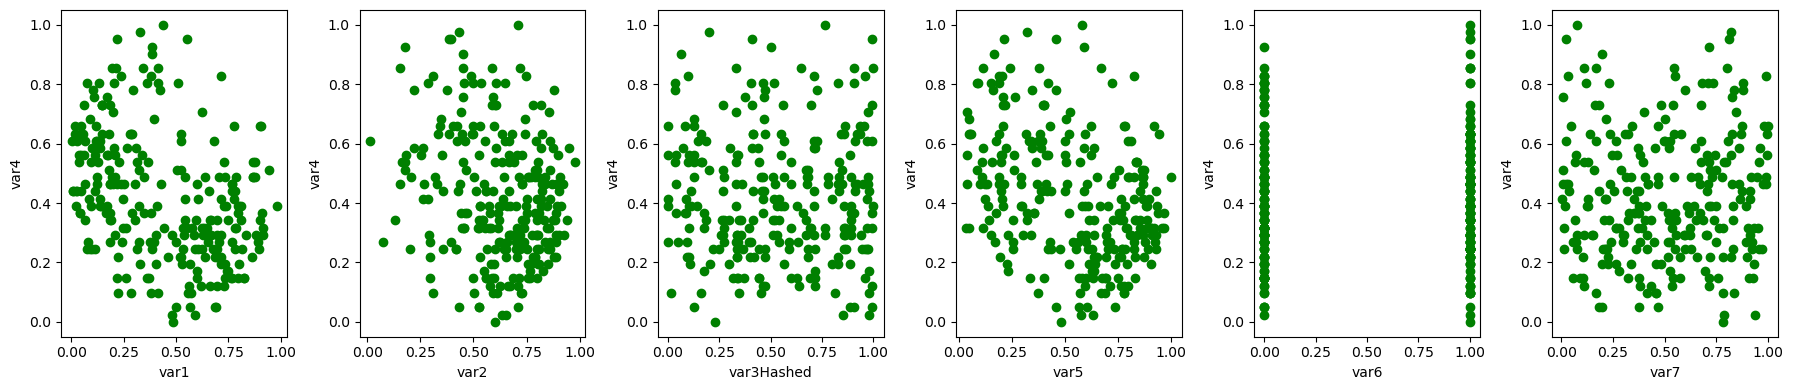

In [19]:
# create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 4))

# scatter plots for each variable
axes[0].scatter(X_train['var1'], y_train, color='g')
axes[0].set_xlabel('var1')
axes[0].set_ylabel('var4')

axes[1].scatter(X_train['var2'], y_train, color='g')
axes[1].set_xlabel('var2')
axes[1].set_ylabel('var4')

axes[2].scatter(X_train['var3Hashed'], y_train, color='g')
axes[2].set_xlabel('var3Hashed')
axes[2].set_ylabel('var4')

axes[3].scatter(X_train['var5'], y_train, color='g')
axes[3].set_xlabel('var5')
axes[3].set_ylabel('var4')

axes[4].scatter(X_train['var6'], y_train, color='g')
axes[4].set_xlabel('var6')
axes[4].set_ylabel('var4')

axes[5].scatter(X_train['var7'], y_train, color='g')
axes[5].set_xlabel('var7')
axes[5].set_ylabel('var4')

# adjust layout for better readability
plt.tight_layout()

# show the plot
plt.show()

We do not observe a linear dependancy between features and 'var4' values. Thus we will try polynomial regression model to predict 'var4' values. For our case we shall use Random Forest regressor.

In [20]:
# create polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# create and fit the Random Forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train_poly, y_train)

# predict on the test set
y_pred = regressor.predict(X_test_poly)

# for comparison purposes, let's store both the actual labels and the predicted labels in a DataFrame
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(res)

       Actual  Predicted
256  0.609756   0.446585
65   0.243902   0.354146
15   0.292683   0.394878
66   0.073171   0.103659
269  0.170732   0.241707
..        ...        ...
52   0.268293   0.327073
222  0.195122   0.251707
218  0.487805   0.512927
56   0.195122   0.257805
317  0.317073   0.300976

[65 rows x 2 columns]


In [21]:
# Calculate evaluation metrics for the current predictions
mse = mean_squared_error(res['Actual'], res['Predicted'])
r2 = r2_score(res['Actual'], res['Predicted'])
mae = mean_absolute_error(res['Actual'], res['Predicted'])
rmse = np.sqrt(mse)

print('Mean Absolute Error:', mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2):", r2)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 0.10749718574108819
Mean Squared Error (MSE): 0.021230459891090476
R-squared (R^2): 0.5305239434076232
Root Mean Squared Error: 0.14570675993614873


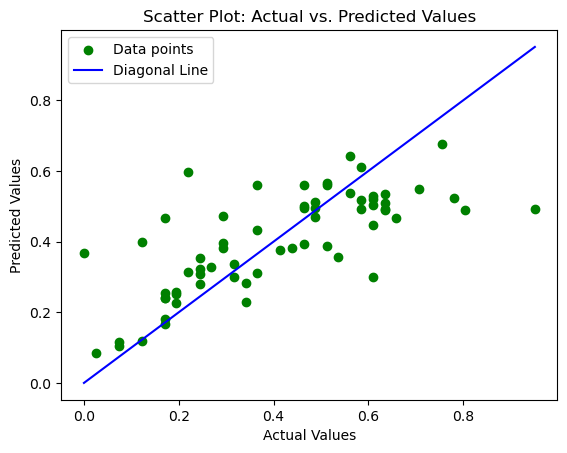

In [22]:
# create a scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, color='g', label='Data points')

# add the diagonal line (identity line)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='b', label='Diagonal Line')

# set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs. Predicted Values')

# show the legend
plt.legend()

# show the plot
plt.show()

For the points in the scatter plot are clustered near the diagonal line, it indicates that the model's predictions are close to the actual values. In other words, the model is making accurate predictions, and there is a strong positive correlation between the predicted and actual values.

For the points that fall directly on the diagonal line (the blue line in the scatter plot) represent perfect predictions, where the model's predicted values exactly match the actual values. 

In [23]:
X_missing = var4_missing[['var1', 'var2','var3Hashed','var5','var6','var7']]

X_missing_poly = poly_features.transform(X_missing)
y_missing = regressor.predict(X_missing_poly)

# replace missing values
var4_missing.loc[:, 'var4'] = y_missing

# combine the complete and imputed data
dataset_pd = pd.concat([var4_complete, var4_missing])
dataset_pd.isna().sum()

/var/folders/5d/rnkft_hs7951vfy1yy2lmd000000gp/T/ipykernel_35008/3227094771.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var4_missing.loc[:, 'var4'] = y_missing


target        0
var1          0
var2          0
var3          0
var4          0
var5          0
var6          0
var7          0
var3Hashed    0
dtype: int64

Now the data prepartion step is complete. Our goal is to predict the values of the 'target' column. This is a classification problem. We will use Random Forest Classifier to train our model.

Let us split the data first keeping the relation between different classes of target values.

In [24]:
# find and print the proportion of positive samples in data
print('% of positive samples in whole data:', sum(dataset_pd['target'] == 1) / len(dataset_pd))

X = dataset_pd[['var1','var2','var3Hashed','var4','var5','var6','var7']]
y = dataset_pd['target']

# splitting the dataset into train (80%) / test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# find and print the proportion of positive samples in train and test sets, makeing sure they are approx same
print('% of positive samples in train set:', sum(y_train== 1) / len(X_train))
print('% of positive samples in test set:', sum(y_test== 1) / len(X_test))

% of positive samples in whole data: 0.4962162162162162
% of positive samples in train set: 0.49594594594594593
% of positive samples in test set: 0.4972972972972973


In [25]:
# visualizing the trianed data
X_train

,var1,var2,var3Hashed,var4,var5,var6,var7
441,0.232171,0.690917,0.833983,0.545366,0.118307,0,0.649055
143,0.800218,0.596229,0.829072,0.195122,0.736699,0,0.227072
104,0.147597,0.600723,0.561828,0.731707,0.218936,0,0.676952
833,0.646446,0.717878,0.373329,0.385122,0.932517,0,0.814127
183,0.229386,0.665623,0.166014,0.536585,0.107768,0,0.957630
...,...,...,...,...,...,...,...
722,0.931348,0.566071,0.104394,0.276341,0.324324,1,0.874966
613,0.415970,0.829713,0.563775,0.269512,0.702703,1,0.197973
677,0.349195,0.384754,0.672662,0.618780,0.148734,0,0.298994
631,0.315958,0.837820,0.698312,0.485610,0.193269,0,0.143202


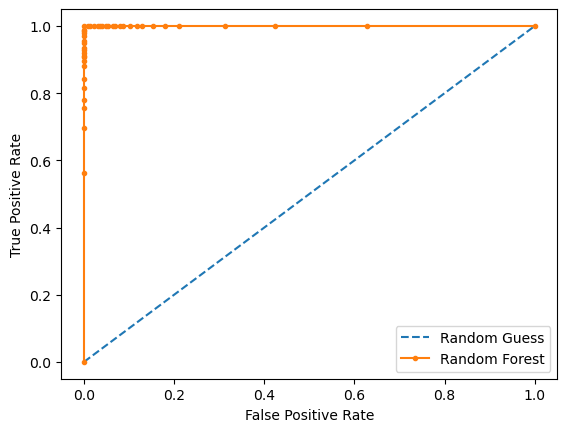

Best Threshold = 0.57


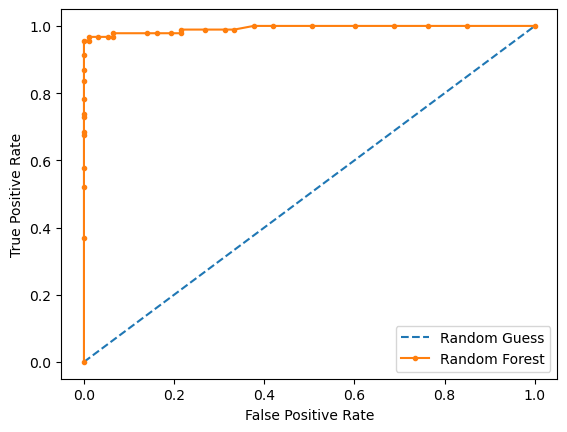

Best Threshold = 0.51
Testing accuracy = 0.972972972972973
Testing precision = 1.0
Testing recall = 0.9456521739130435


In [26]:
def predictWithThreshold(model, X, y, threshold=np.NaN):
    # get predicted probabilities
    y_hat = model.predict_proba(X)[:, 1]

    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_hat)

    # plot the ROC curve and the diagonal line
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.plot(fpr, tpr, marker='.', label='Random Forest')

    # axis labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # show the plot
    plt.show()

    # calculate the Youden's J statistic to find the best threshold
    J = tpr - fpr
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold =', best_thresh)

    if not np.isnan(threshold):
        best_thresh = threshold

    # create binary predictions using the best threshold
    pred_df = pd.DataFrame({'Predicted': y_hat}).applymap(lambda x: 1 if x > best_thresh else 0)

    return pred_df, best_thresh


# create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train, y_train)

# call the predictWithThreshold function
y_train_pred, best_threshold = predictWithThreshold(rf_classifier, X_train, y_train)

# use the best threshold for binary classification on test data
y_test_pred, _ = predictWithThreshold(rf_classifier, X_test, y_test, threshold=best_threshold)

# calculate and print evaluation metrics
print('Testing accuracy =', accuracy_score(y_test, y_test_pred.Predicted))
print('Testing precision =', precision_score(y_test, y_test_pred.Predicted))
print('Testing recall =', recall_score(y_test, y_test_pred.Predicted))

From the output of the Best Threshold value, a probability greater than or equal to 0.51 is considered as the positive class (1), and a probability less than 0.51 is considered as the negative class (0). This threshold was selected based on maximizing the Youden's J statistic, which balances the true positive rate (recall) and the true negative rate (1 - false positive rate) to find an optimal trade-off.
For the Testing accuracy in our case, the Random Forest classifier has achieved an accuracy of approximately 97.30% on the test data. This indicates that it correctly predicted the class labels for about 97.30% of the samples in the test set.
For the Testing precision in our case, the precision is approximately 100.00%, indicating that when the model predicted a sample as positive (1), it was correct for 100.00% of the time.
For the Testing recall in our case, the recall is approximately 94.57%, indicating that the model correctly identified about 94.57% of the actual positive samples in the test set.

In [27]:
# calculate the difference between the predicted values and the true values in the test set 
t = y_test_pred.Predicted - y_test.values 
print('Values difference: {}'.format(t.sum()))

Values difference: -5


The difference between the predicted values and the true values in the test set is -5.
This means that there are more false negatives than false positives in the test set. 

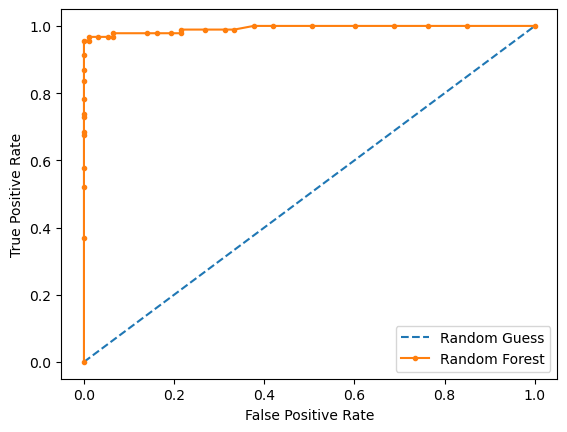

Best Threshold = 0.51
Testing accuracy = 0.972972972972973
Testing precision = 0.9887640449438202
Testing recall = 0.9565217391304348


In [28]:
# evaluating the performance of a Random Forest classifier on the test data
y_test_pred, threshold = predictWithThreshold(rf_classifier, X_test, y_test)

print('Testing accuracy = {}'.format(accuracy_score(y_test, y_test_pred.Predicted)))
print('Testing precision = {}'.format(precision_score(y_test, y_test_pred.Predicted)))
print('Testing recall = {}'.format(recall_score(y_test, y_test_pred.Predicted)))

Testing accuracy value (0.972972972972973) indicates that the model achieved approximately 97.3% accuracy on the test data. 
Testing precision value (0.9887640449438202) indicates that the model achieved a very high percentage (about 99%) of true positive predictions out of all the positive predictions.
A Testing recall of 0.957 indicates that the model captured approximately 95.7% of the true positive samples.

In [29]:
# calculate the difference between the predicted values and the true values in the test set 
t = y_test_pred.Predicted - y_test.values
print('Values difference: {}'.format(t.sum()))

Values difference: -3


The difference between the predicted test values and the true test values in the test set is -3. This means that there are more false negatives than false positives in the test set. This shows that the number of correct predictions (True Positives + True Negatives) is 3 more than the number of incorrect predictions (False Positives + False Negatives). This shwos that the model is performing well in terms of minimizing false negatives, which is very important in areas of application where avoiding false negatives is crucial such as fraud detection or medical diagnosis purposes. 

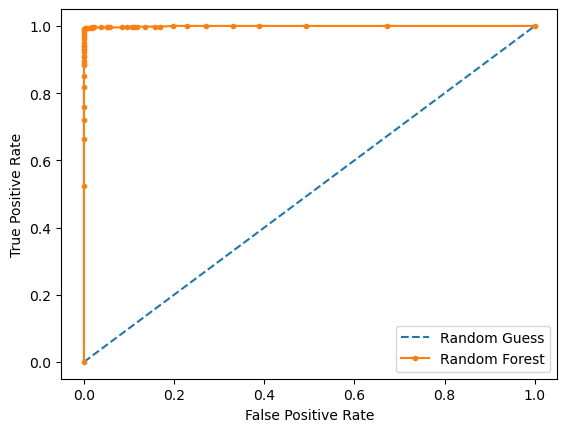

Best Threshold = 0.51
Testing accuracy = 0.9945945945945946
Testing precision = 0.9978070175438597
Testing recall = 0.9912854030501089


In [30]:
# use the trained model to predict for the complete dataset
y_complete_pred, threshold2 = predictWithThreshold(rf_classifier, X, y, threshold)

print('Testing accuracy = {}'.format(accuracy_score(y, y_complete_pred.Predicted)))
print('Testing precision = {}'.format(precision_score(y, y_complete_pred.Predicted)))
print('Testing recall = {}'.format(recall_score(y, y_complete_pred.Predicted)))

Testing Accuracy (0.9945945945945946): The model achieves an accuracy of approximately 99.46%. This means that around 99.46% of the predictions made by the model on the complete dataset are correct.
Testing Precision (0.9978070175438597): The precision score is approximately 99.78%. This indicates that when the model predicts an instance as positive (1), it is correct around 99.78% of the time. This means the model has a very low false positive rate.
Testing Recall (0.9912854030501089): The recall score is approximately 99.13%. This means that the model correctly identifies around 99.13% of the actual positive instances in the dataset. This means the model has a low false negative rate.

In [31]:
t = y_complete_pred.Predicted - y.values
print('Values difference: {}'.format(t.sum()))

dataset_pd['target_prediction'] = y_complete_pred.Predicted

dataset_pd

Values difference: -3


,target,var1,var2,var3,var4,var5,var6,var7,var3Hashed,target_prediction
0,0,0.906950,0.424070,Micronesia,0.658537,0.781914,0,0.983027,0.081415,0
1,0,0.715886,0.803528,Dominica,0.195122,0.642699,1,0.459632,0.108762,0
2,1,0.078520,0.394165,Isle of Man,0.268293,0.598334,0,0.298817,0.591861,1
3,0,0.291985,0.577505,Turkmenistan,0.365854,0.939147,1,0.378358,0.464784,0
4,0,0.737135,0.702707,Cameroon,0.390244,0.883733,0,0.374547,0.889349,0
...,...,...,...,...,...,...,...,...,...,...
920,0,0.644085,0.621934,Belarus,0.094390,0.637260,1,0.104572,0.955990,0
921,1,0.402773,0.509945,Japan,0.717073,0.128676,0,0.153982,0.679418,1
922,1,0.168120,0.608055,Saint Martin,0.534146,0.154173,1,0.802583,0.983677,1
923,0,0.567744,0.736652,Chad,0.345122,0.919429,1,0.716604,0.450871,0


The value -3 means that there are 3 more negative predictions than actual negative instances in the complete dataset. This means the model is slightly biased towards predicting negative instances. False negatives can be problematic in certain applications, where the consequences of missing positive instances are severe.

So k-fold cross-validation tuning can be a useful approach to fine-tune the model and find an optimal threshold. K-fold cross-validation can help in better estimating the model's performance by reducing the bias and variance of the evaluation metrics.

In [32]:
# try k-Fold cross validation tuning
# rreate a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# perform k-fold cross-validation 
k_folds = 5 # for our k_folds we shall try 5
scores = cross_val_score(rf_classifier, X, y, cv=k_folds, scoring='accuracy')

# print the accuracy scores for each fold and the mean accuracy
for i, score in enumerate(scores):
    print(f'Fold {i+1} - Accuracy: {score}')

print(f'Mean Accuracy: {np.mean(scores)}')
print(f'Standard Deviation of the fold: {np.std(scores)}')

Fold 1 - Accuracy: 0.9621621621621622
Fold 2 - Accuracy: 0.9567567567567568
Fold 3 - Accuracy: 0.9513513513513514
Fold 4 - Accuracy: 0.9675675675675676
Fold 5 - Accuracy: 0.9297297297297298
Mean Accuracy: 0.9535135135135135
Standard Deviation of the fold: 0.01306275240388601


Based on the output of k-fold cross-validation, we can see that the random forest model achieved a mean accuracy across all folds of approximately 0.9535, and the standard deviation of the accuracy of approximately 0.013.This shows that our model is performing well and providing consistent accuracy across different subsets of the data during the k-fold cross-validation process. It indicates that the model generalizes well to unseen data and is not overfitting to the training set.

We need to evaluate the performance of a classification model on a set of test data for which the true values are known. For this, we shall use the confusion matrix to show a detailed breakdown of the model's prediction. 

Intepretation of the confusion matrix

TN (True Negative) | FP (False Positive)
-------------------|-------------------
FN (False Negative)| TP (True Positive)


In [33]:
# split data into training and testing sets
test_size = 0.2
seed = 0  # initialize the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# create and train the Random Forest classifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# make predictions on the test data
predicted = model.predict(X_test)

# compute the confusion matrix
matrix = confusion_matrix(y_test, predicted)

# print the confusion matrix
print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[85  6]
 [ 7 87]]


#### Intepretation of the confusion matrix

TN (True Negative) | FP (False Positive)
-------------------|-------------------
FN (False Negative)| TP (True Positive)  from this intepretation TN = 85, FP = 6, FN = 7, TP = 87 based on 20% of the test size data. 

Accuracy: (TN + TP) / (TN + FP + FN + TP) = 0.9297

Precision:  TP / (TP + FP) = 0.9354

Recall (Sensitivity or True Positive Rate):  TP / (TP + FN) = 0.9255

Specificity (True Negative Rate):  TN / (TN + FP) = 0.9255

F1-Score: 2 * (Precision * Recall) / (Precision + Recall) = 0.9264

## Summary: 
The model shows good performance in classifying instances into positive and negative classes. The balanced F1-Score suggests that the model is capable of making accurate predictions while maintaining a good balance between correctly identifying positive instances and avoiding false positives.

We shall do a performing feature importance analysis for our Random Forest classifier. The goal is to determine the relative importance of each feature in predicting the target variable. By analyzing the feature importances, we can identify which features are the most relevant in making predictions and gain insights into the underlying relationships between the features and the target variable. This analysis can help in feature selection, model optimization, and understanding the key factors influencing the model's predictions.

<AxesSubplot:ylabel='Feature'>

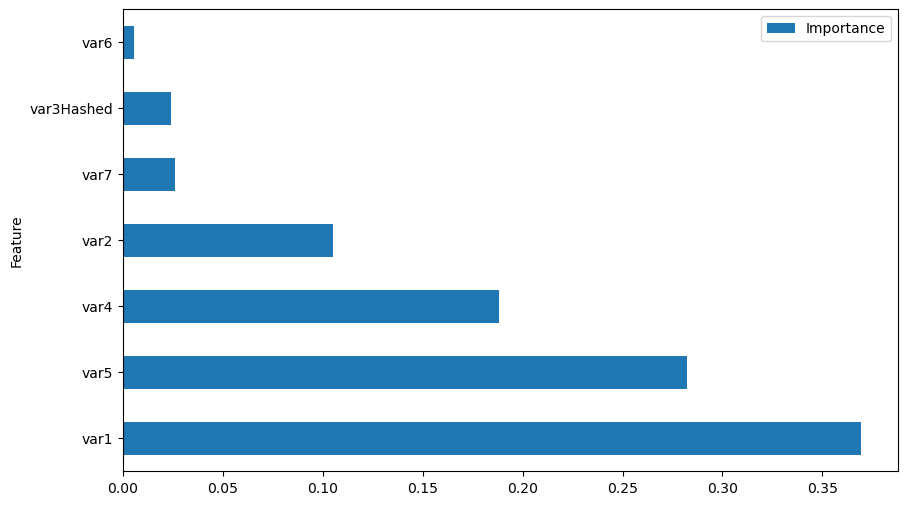

In [34]:
# split data into training and testing sets
test_size = 0.3
seed = 0  # initialize the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# create and train the Random Forest classifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# get the feature importances
importances = model.feature_importances_

# create a DataFrame to store feature importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# plot the feature importances
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

From the output we can see var1 and var5 are the most important features. With var1 being the most important feature.